In [3]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, GlobalAveragePooling1D, Conv2D, ConvLSTM2D, ConvLSTM1D, Input, Flatten, Reshape, TextVectorization, concatenate
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
#from tensorflow.keras import ops
import keras
import numpy as np

tf.config.run_functions_eagerly(True)


In [4]:
"""Vars"""
sample_headlines = ["Hoo Hoo", "HOO", "WHOSE TOES", "HOO", "Hoo hoo hoo"]
sample_prices = [34.3, 40.4, 90, 30, 0.5]
sample_gains = [0] + [(sample_prices[i+1]-sample_prices[i])/sample_prices[i] for i in range(0, len(sample_prices)-1)]
var_duration = 2
sample_vars = [0 for i in range(var_duration)] + [np.std(sample_prices[i:i+var_duration]) for i in range(0, len(sample_prices)-var_duration)]
print("sample gains: ", sample_gains)
print("smaple vars: ", sample_vars)
#print("zipped: ", np.array(zip(np.array(sample_gains), np.array(sample_vars))))
zipped_labels = [[sample_gains[i], sample_vars[i]] for i in range(len(sample_gains))]
print("zipped: ", zipped_labels)

vocab_size = 50
max_len = 30
embeddings_dim = 1#5

num_past_prices = 30


sample gains:  [0, 0.1778425655976677, 1.2277227722772277, -0.6666666666666666, -0.9833333333333333]
smaple vars:  [0, 0, 3.0500000000000007, 24.8, 30.0]
zipped:  [[0, 0], [0.1778425655976677, 0], [1.2277227722772277, 3.0500000000000007], [-0.6666666666666666, 24.8], [-0.9833333333333333, 30.0]]


In [5]:
"""Encoder Methods"""
def get_one_hot_encoded_batch(vocab_size, strings):
    return [one_hot(string, vocab_size) for string in strings]

def pad_input(max_len, one_hot_encoded_strings):
    return pad_sequences(one_hot_encoded_strings, maxlen=max_len)



In [6]:
"""Encoder Architecture"""
input = Input(shape=(max_len))
embeddings_1 = Embedding(input_dim=vocab_size, output_dim=embeddings_dim, input_length=max_len)(input) # look at TextVecotirzation
#flatten_1 = Flatten()(embeddings_1) 
#reshape_1 = Reshape((max_len, -1))(embeddings_1)
lstm_1 = LSTM(units=30, return_sequences=False)(embeddings_1) # Default activation tanh - VERIFY
dense_1 = Dense(units=30)(lstm_1)
dense_2 = Dense(units=1)(dense_1)
output = dense_2 # Perhaps more to come

encoder = keras.Model(inputs = input, outputs = output)
encoder.compile(optimizer="rmsprop", loss="mse")
print(encoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 1)             50        
                                                                 
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 4851 (18.95 KB)
Trainable params: 4851 (18.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [7]:
"""Encoder Architecture 2
input = Input(shape=(max_len, vocab_size))
embeddings_1 = Embedding(input_dim=vocab_size, output_dim=embeddings_dim, input_length=max_len)(input)
#flatten_1 = Flatten()(embeddings_1)
reshape_1 = Reshape((max_len, vocab_size))(embeddings_1)
lstm_1 = LSTM(units=30, return_sequences=False)(reshape_1) # Default activation tanh - VERIFY
dense_1 = Dense(units=30)(lstm_1)
dense_2 = Dense(units=2)(dense_1)
output = dense_2 # Perhaps more to come

encoder = keras.Model(inputs = input, outputs = output)
encoder.compile(optimizer="rmsprop", loss="mse")
print(encoder.summary())"""

'Encoder Architecture 2\ninput = Input(shape=(max_len, vocab_size))\nembeddings_1 = Embedding(input_dim=vocab_size, output_dim=embeddings_dim, input_length=max_len)(input)\n#flatten_1 = Flatten()(embeddings_1)\nreshape_1 = Reshape((max_len, vocab_size))(embeddings_1)\nlstm_1 = LSTM(units=30, return_sequences=False)(reshape_1) # Default activation tanh - VERIFY\ndense_1 = Dense(units=30)(lstm_1)\ndense_2 = Dense(units=2)(dense_1)\noutput = dense_2 # Perhaps more to come\n\nencoder = keras.Model(inputs = input, outputs = output)\nencoder.compile(optimizer="rmsprop", loss="mse")\nprint(encoder.summary())'

In [8]:
"""Data Processing"""
one_hots = get_one_hot_encoded_batch(vocab_size=vocab_size, strings=sample_headlines)
padded_one_hots = pad_input(max_len=max_len, one_hot_encoded_strings=one_hots)
print(padded_one_hots)
dataset = tf.data.Dataset.from_tensor_slices(sample_headlines)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  5  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0 14  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  5  5  5]]


In [9]:
"""Model Training"""
encoder.fit(x=padded_one_hots, y=np.array(zipped_labels), epochs=10)#np.array(zip(sample_gains, sample_vars)))

Epoch 1/10
1/1 [==============================] - 0s 73ms/step - loss: 152.7998
Epoch 2/10
1/1 [==============================] - 0s 29ms/step - loss: 152.2838
Epoch 3/10


/opt/homebrew/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 30ms/step - loss: 151.8496
Epoch 4/10
1/1 [==============================] - 0s 30ms/step - loss: 151.3694
Epoch 5/10
1/1 [==============================] - 0s 29ms/step - loss: 150.7899
Epoch 6/10
1/1 [==============================] - 0s 29ms/step - loss: 150.0512
Epoch 7/10
1/1 [==============================] - 0s 29ms/step - loss: 149.0635
Epoch 8/10
1/1 [==============================] - 0s 29ms/step - loss: 147.6622
Epoch 9/10
1/1 [==============================] - 0s 29ms/step - loss: 145.5144
Epoch 10/10
1/1 [==============================] - 0s 28ms/step - loss: 141.9453


In [10]:
"""Encoder Architecture 3"""
input = Input(shape=(1, ), dtype=tf.string)

tv_layer = TextVectorization(max_tokens=1000, output_mode='int', output_sequence_length=max_len)
tv_layer.adapt(dataset.batch(64))

tv_layer_1 = tv_layer(input)
embeddings_1 = Embedding(input_dim=vocab_size, output_dim=embeddings_dim, input_length=max_len)(tv_layer_1)
#flatten_1 = Flatten()(embeddings_1)
#reshape_1 = Reshape((max_len, vocab_size))(embeddings_1)
lstm_1 = LSTM(units=30, return_sequences=False)(embeddings_1) # Default activation tanh - VERIFY
dense_1 = Dense(units=30)(lstm_1)
dense_2 = Dense(units=2)(dense_1)
output = dense_2 # Perhaps more to come

encoder = keras.Model(inputs = input, outputs = output)
encoder.compile(optimizer="rmsprop", loss="mse")
print(encoder.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 30)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 30, 1)             50        
                                                                 
 lstm_1 (LSTM)               (None, 30)                3840      
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 2)                 62        
                                                           

In [11]:
"""Model Training"""
encoder.fit(x=np.array(sample_headlines), y=np.array(zipped_labels), epochs=10)#np.array(zip(sample_gains, sample_vars)))

Epoch 1/10
1/1 [==============================] - 0s 43ms/step - loss: 152.6866
Epoch 2/10
1/1 [==============================] - 0s 31ms/step - loss: 152.0752
Epoch 3/10
1/1 [==============================] - 0s 30ms/step - loss: 151.5200
Epoch 4/10
1/1 [==============================] - 0s 29ms/step - loss: 150.8949
Epoch 5/10
1/1 [==============================] - 0s 30ms/step - loss: 150.1284
Epoch 6/10
1/1 [==============================] - 0s 30ms/step - loss: 149.1373
Epoch 7/10
1/1 [==============================] - 0s 30ms/step - loss: 147.7799
Epoch 8/10
1/1 [==============================] - 0s 29ms/step - loss: 145.7882
Epoch 9/10
1/1 [==============================] - 0s 29ms/step - loss: 142.6240
Epoch 10/10
1/1 [==============================] - 0s 29ms/step - loss: 137.1043


In [12]:
"""Encoder Architecture 4"""
input = Input(shape=(1, ), dtype=tf.string)

tv_layer = TextVectorization(max_tokens=1000, output_mode='int', output_sequence_length=max_len)
tv_layer.adapt(dataset.batch(64))

tv_layer_1 = tv_layer(input)
embeddings_1 = Embedding(input_dim=vocab_size, output_dim=embeddings_dim, input_length=max_len)(tv_layer_1)
#flatten_1 = Flatten()(embeddings_1)
#reshape_1 = Reshape((max_len, vocab_size))(embeddings_1)
lstm_1 = LSTM(units=30, return_sequences=False)(embeddings_1) # Default activation tanh - VERIFY
#dense_1 = Dense(units=30)(lstm_1)
output = lstm_1#dense_1


encoder = keras.Model(inputs = input, outputs = output)
encoder.compile(optimizer="rmsprop", loss="mse")
print(encoder.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 30)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 30, 1)             50        
                                                                 
 lstm_2 (LSTM)               (None, 30)                3840      
                                                                 
Total params: 3890 (15.20 KB)
Trainable params: 3890 (15.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_gains (InputLayer)    [(None, 30)]                 0         []                            
                                                                                                  
 reshape_3 (Reshape)         (None, 30, 1)                0         ['input_gains[0][0]']         
                                                                                                  
 input_headlines (InputLaye  [(None, 1)]                  0         []                            
 r)                                                                                               
                                                                                                  
 lstm_13 (LSTM)              (None, 30, 64)               16896     ['reshape_3[0][0]']     

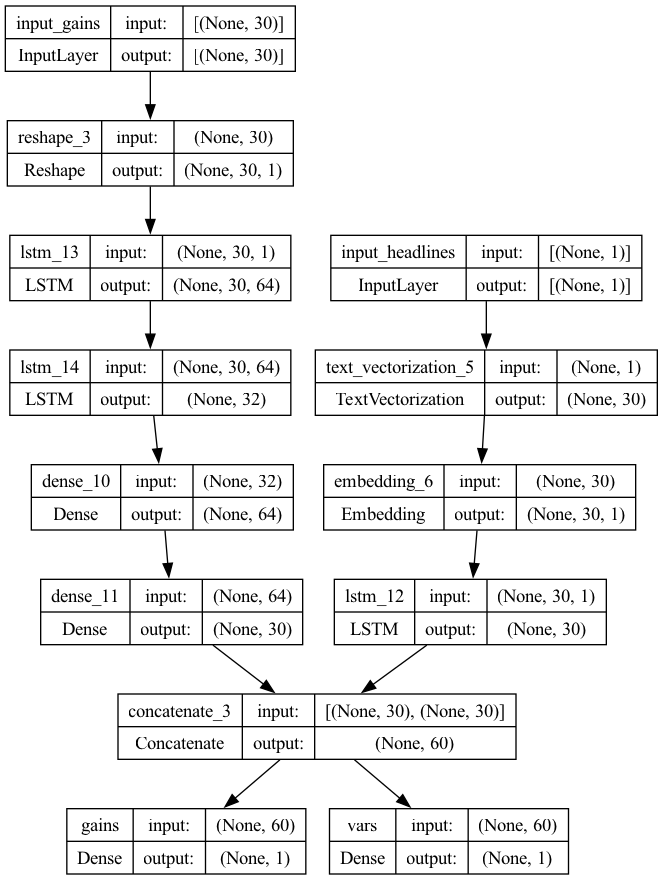

In [22]:
dataset = tf.data.Dataset.from_tensor_slices(sample_headlines)
"""Total arch"""
# Headline Encoder
input_headlines = Input(shape=(1, ), dtype=tf.string, name="input_headlines")

tv_layer = TextVectorization(max_tokens=1000, output_mode='int', output_sequence_length=max_len)
tv_layer.adapt(dataset.batch(64))

tv_layer_1 = tv_layer(input_headlines)
embeddings_1 = Embedding(input_dim=vocab_size, output_dim=embeddings_dim, input_length=max_len)(tv_layer_1)
lstm_1 = LSTM(units=30, return_sequences=False)(embeddings_1) # Default activation tanh
embedded_headlines = lstm_1 # More to compe perhaps

# Stock Gain Encoder
input_gains = Input(shape=(num_past_prices), name="input_gains")
inp_reshaped = Reshape((num_past_prices, 1))(input_gains)
#g_lstm_1 = ConvLSTM1D(filters=32, kernel_size=5, padding='same')(inp_reshaped) TODO
g_lstm_1 = LSTM(units=64, return_sequences=True)(inp_reshaped)
g_lstm_2 = LSTM(units=32, return_sequences=False)(g_lstm_1)

# Dense
g_dense_1 = Dense(units=64, activation='relu')(g_lstm_2)
g_dense_2 = Dense(units=30)(g_dense_1)

# Concat with headlines embeddings
concatted_gains_embeds = concatenate([embedded_headlines, g_dense_2])

# output dense layers
out_dense_1 = Dense(units = 1, name="gains")(concatted_gains_embeds)
out_dense_2 = Dense(units = 1, name="vars")(concatted_gains_embeds)

model = keras.Model(
    inputs = [input_headlines, input_gains], 
    outputs = {"gains":out_dense_1, "vars":out_dense_2}
)

model.compile(optimizer="adam", loss="mean_squared_error")
         #     loss={
         #         "gains":,
         #         "vars":
         #     })
print(model.summary())
keras.utils.plot_model(model, "sussamodel.png", show_shapes=True)

In [23]:
"""Training megamodel"""
# Make dummy data
dummy_headlines = np.array(["hoo", "HOO HOO HOO", "ahhhh", "d", "dfs"], dtype=str)
dummy_gains_in = np.random.rand(5, num_past_prices)
dummy_gains_out = np.random.rand(5, num_past_prices)
dummy_vars = np.random.rand(5, num_past_prices)

# Train
model.fit(
    {"input_headlines": dummy_headlines, "input_gains": dummy_gains_in},
    {"gains": dummy_gains_out, "vars": dummy_vars},
    epochs=2,
    batch_size=32,
)

Epoch 1/2
1/1 [==============================] - 0s 108ms/step - loss: 0.6942 - gains_loss: 0.3406 - vars_loss: 0.3536
Epoch 2/2


/opt/homebrew/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 85ms/step - loss: 0.6194 - gains_loss: 0.2996 - vars_loss: 0.3198
